In [1]:
%matplotlib inline

In [2]:
import os
import pathlib as pal
import scipy as sp
import numpy as np
import pandas as pd
import patsy as pat
import seaborn as sbn
import nibabel as nib
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy import io as sio
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import metrics as skm
from sklearn import linear_model as sln
from sklearn import preprocessing as skp
from statsmodels.sandbox.stats.multicomp import multipletests as stm

In [3]:
root_p = pal.Path('/home/surchs/data/')
dc16_p = root_p / 'paper_16p22q/glm/16p_age/cambridge64/del_minus_con/glm_del_minus_con_cambridge64.mat'
dc22_p = root_p / 'paper_16p22q/glm/22q/cambridge64/del_minus_con/glm_del_minus_con_cambridge64.mat'

abide_p = root_p / 'paper_16p22q/glm/abide/cambridge64/individual'
conn_t = 'connectome_s{}_cambridge64.mat'
pheno_p = root_p / 'paper_16p22q/pheno/abide_men.csv'
labels_p = root_p / 'ATLAS/MIST/Parcel_Information/MIST_64.csv'
atlas_p = root_p / 'ATLAS/MIST/Parcellations/MIST_64.nii.gz'
figure_p = root_p / 'paper_16p22q/figures/unclear'

In [4]:
# Get the pheno file
pheno = pd.read_csv(pheno_p)
labels = pd.read_csv(labels_p, delimiter=';')

In [5]:
# Load the MIST64 template
temp_i = nib.load(str(atlas_p))
mist64 = temp_i.get_data()

In [6]:
def octvec2mat(vec, mask):
    """
    Takes a vector in Fortran style (Octave/Matlab)
    and maps it back into a mask correctly in 
    python
    """
    vec_mat = mask.flatten(order='F').astype(bool)
    tmp = np.zeros_like(vec_mat, dtype=float)
    tmp[vec_mat] = vec
    vol = np.reshape(tmp, mask.shape, order='F')
    return vol

In [7]:
def vec2mat(vec, mask):
    tmp_mat = octvec2mat(vec, mask)
    tmp_mat += tmp_mat.T
    tmp_mat[np.eye(mask.shape[0]).astype(bool)] = tmp_mat[np.eye(mask.shape[0]).astype(bool)]/2
    return tmp_mat

In [8]:
# Get the connectomes
conn = np.array([sio.loadmat(str(abide_p / conn_t.format(row['SUB_ID'])))['asd_con']['connectome'][0][0]
        for rid, row in pheno.iterrows()]).squeeze()

In [9]:
# Prepare regression, with control as reference
model = pat.dmatrix('SITE_ID+FD_scrubbed+AGE_AT_SCAN', data=pheno, return_type='dataframe')

In [10]:
# Run the glm
mod = sln.LinearRegression(fit_intercept=False, normalize=True)
res = mod.fit(model, conn)
# Get the residuals
resid = conn - res.predict(model)

In [11]:
resid_mat = np.array([vec2mat(resid[i, :], np.tril(np.ones((64,64))).astype(bool)) for i in range(resid.shape[0])])
abide_mat = np.array([resid_mat[i, ...] + resid_mat[i, ...].T for i in range(resid_mat.shape[0])])
# Remove duplicates on diagnonal
diag = abide_mat[..., np.identity(64, dtype=bool)]
abide_mat[..., np.identity(64, dtype=bool)] = diag/2

In [12]:
# Get the reference
dc16_pattern = np.array(sio.loadmat(dc16_p)['eff']).squeeze()
# Map back to matrix
dc16_refm = octvec2mat(dc16_pattern, np.tril(np.ones((64,64))).astype(bool))
dc16_refm += dc16_refm.T
dref = dc16_refm[np.identity(64, dtype=bool)]
dc16_refm[np.identity(64, dtype=bool)] = dref/2

In [13]:
# Get the reference
dc22_pattern = np.array(sio.loadmat(dc22_p)['eff']).squeeze()
# Map back to matrix
dc22_refm = octvec2mat(dc22_pattern, np.tril(np.ones((64,64))).astype(bool))
dc22_refm += dc22_refm.T
dref = dc22_refm[np.identity(64, dtype=bool)]
dc22_refm[np.identity(64, dtype=bool)] = dref/2

In [14]:
# Make weights for each node
w_abide_16p = np.zeros((abide_mat.shape[0], dc16_refm.shape[0]))
for i in range(64):
    for j in range(abide_mat.shape[0]):
        w_abide_16p[j, i] = np.corrcoef(dc16_refm[i, :], abide_mat[j, i, :])[0,1]

In [15]:
# Make weights for each node
w_abide_22q = np.zeros((abide_mat.shape[0], dc22_refm.shape[0]))
for i in range(64):
    for j in range(abide_mat.shape[0]):
        w_abide_22q[j, i] = np.corrcoef(dc22_refm[i, :], abide_mat[j, i, :])[0,1]

## Go for the diagnosis

In [16]:
con_idx = pheno['DX_GROUP']=='Control'
n_con = np.sum(con_idx)
n_asd = np.sum(~con_idx)
pl = list()
pid = list()
eff_l = list()
eff_ls = list()
gt = list()
for i in range(64):
    u_min, p = sp.stats.mannwhitneyu(w_abide_22q[~con_idx, i], w_abide_22q[con_idx, i], alternative=None)
    u_right, ppp = sp.stats.mannwhitneyu(w_abide_22q[~con_idx, i], w_abide_22q[con_idx, i], alternative='two-sided')
    eff = 1 - (2*u_min) / (n_asd*n_con)
    del_gt_con = u_right > u_min
    pl.append(p)
    if del_gt_con:
        eff_ls.append(eff)
    else:
        eff_ls.append(-eff)
    if p < 0.05:
        #print(i+1, p, u_min, eff, del_gt_con)
        pid.append(i)
        gt.append(del_gt_con)
        if del_gt_con:
            eff_l.append(eff)
        else:
            eff_l.append(-eff)

In [17]:
dx_ind = np.where(stm(pl, alpha=0.05, method='fdr_bh')[0])[0]
p_corrected = stm(pl, alpha=0.05, method='fdr_bh')[1]

In [18]:
len(dx_ind)

18

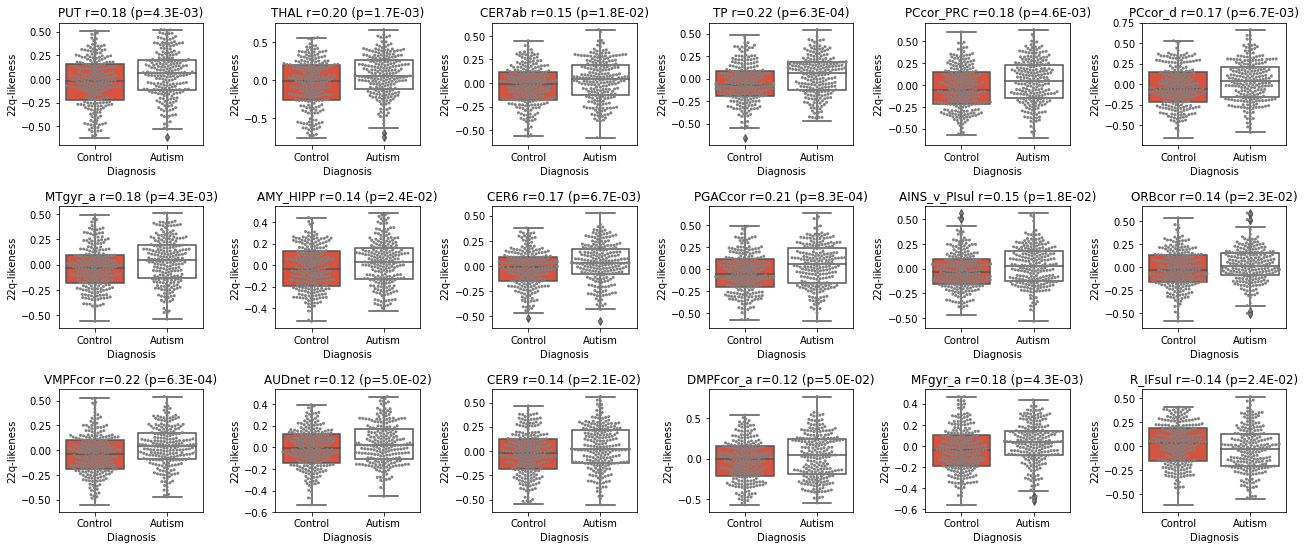

In [19]:
# We have 18 significant tests
f = plt.figure(figsize=(22,9))
gsp = gridspec.GridSpec(3, 6, hspace=0.5, wspace=0.5)
for fig_id, ind in enumerate(dx_ind):
    r_name = labels[labels['roi']==ind+1]['label'].values[0]
    ax = f.add_subplot(gsp[fig_id])
    p = pheno.copy()
    p['weights'] = w_abide_22q[:, ind]
    sbn.boxplot(y='weights', x='DX_GROUP', data=p, ax=ax, palette=sbn.xkcd_palette(['tomato', 'white']))
    sbn.swarmplot(y='weights', x='DX_GROUP', data=p, ax=ax, color='grey', size=3)
    ax.set_ylabel('22q-likeness')
    ax.set_xlabel('Diagnosis')
    ax.set_title('{} r={:.2f} (p={:.1E})'.format(r_name, eff_ls[ind], p_corrected[ind]))
f.savefig(os.path.join(figure_p, 'abide_22q_enrichment_regions.pdf'), dpi=300, bbox_inches='tight', pad_inches=0)

## Now compare this to the 16p signature

In [20]:
con_idx = pheno['DX_GROUP']=='Control'
n_con = np.sum(con_idx)
n_asd = np.sum(~con_idx)
pl_p16 = list()
eff_ls_p16 = list()

for i in range(64):
    u_min, p = sp.stats.mannwhitneyu(w_abide_16p[~con_idx, i], w_abide_16p[con_idx, i], alternative=None)
    u_right, ppp = sp.stats.mannwhitneyu(w_abide_16p[~con_idx, i], w_abide_16p[con_idx, i], alternative='two-sided')
    eff = 1 - (2*u_min) / (n_asd*n_con)
    del_gt_con = u_right > u_min
    pl_p16.append(p)
    if del_gt_con:
        eff_ls_p16.append(eff)
    else:
        eff_ls_p16.append(-eff)

In [21]:
dx_ind_p16 = np.where(stm(pl_p16, alpha=0.05, method='fdr_bh')[0])[0]
p_corrected_16 = stm(pl_p16, alpha=0.05, method='fdr_bh')[1]

In [22]:
len(dx_ind_p16)

7

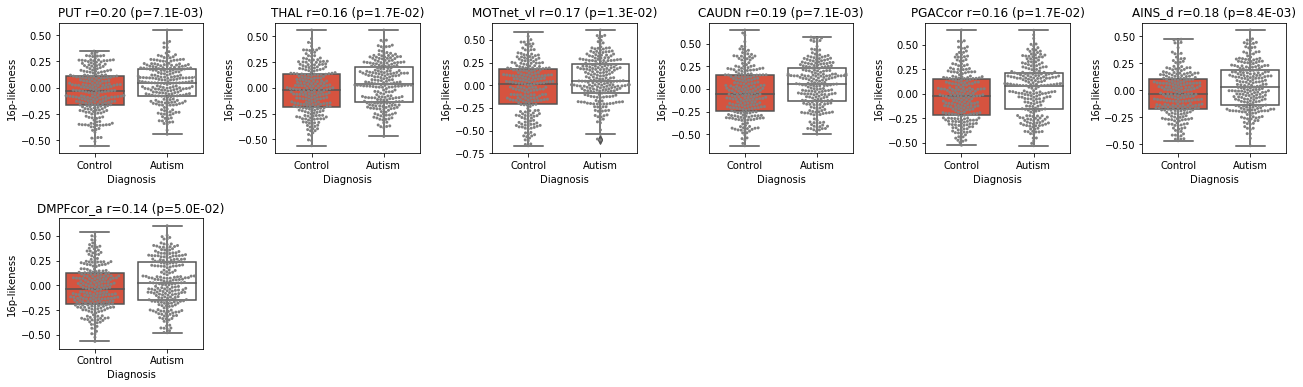

In [23]:
# We have 11 significant tests
f = plt.figure(figsize=(22,6))
gsp = gridspec.GridSpec(2, 6, hspace=0.5, wspace=0.5)
for fig_id, ind in enumerate(dx_ind_p16):
    r_name = labels[labels['roi']==ind+1]['label'].values[0]
    ax = f.add_subplot(gsp[fig_id])
    p = pheno.copy()
    p['weights'] = w_abide_16p[:, ind]
    sbn.boxplot(y='weights', x='DX_GROUP', data=p, ax=ax, palette=sbn.xkcd_palette(['tomato', 'white']))
    sbn.swarmplot(y='weights', x='DX_GROUP', data=p, ax=ax, color='grey', size=3)
    ax.set_ylabel('16p-likeness')
    ax.set_xlabel('Diagnosis')
    ax.set_title('{} r={:.2f} (p={:.1E})'.format(r_name, eff_ls_p16[ind], p_corrected_16[ind]))
f.savefig(os.path.join(figure_p, 'abide_16p_enrichment_regions.pdf'), dpi=300, bbox_inches='tight', pad_inches=0)

Looks close enough

In [24]:
overlap_networks = list(set(list(dx_ind_p16)).intersection(list(dx_ind)))

In [25]:
len(overlap_networks)

4

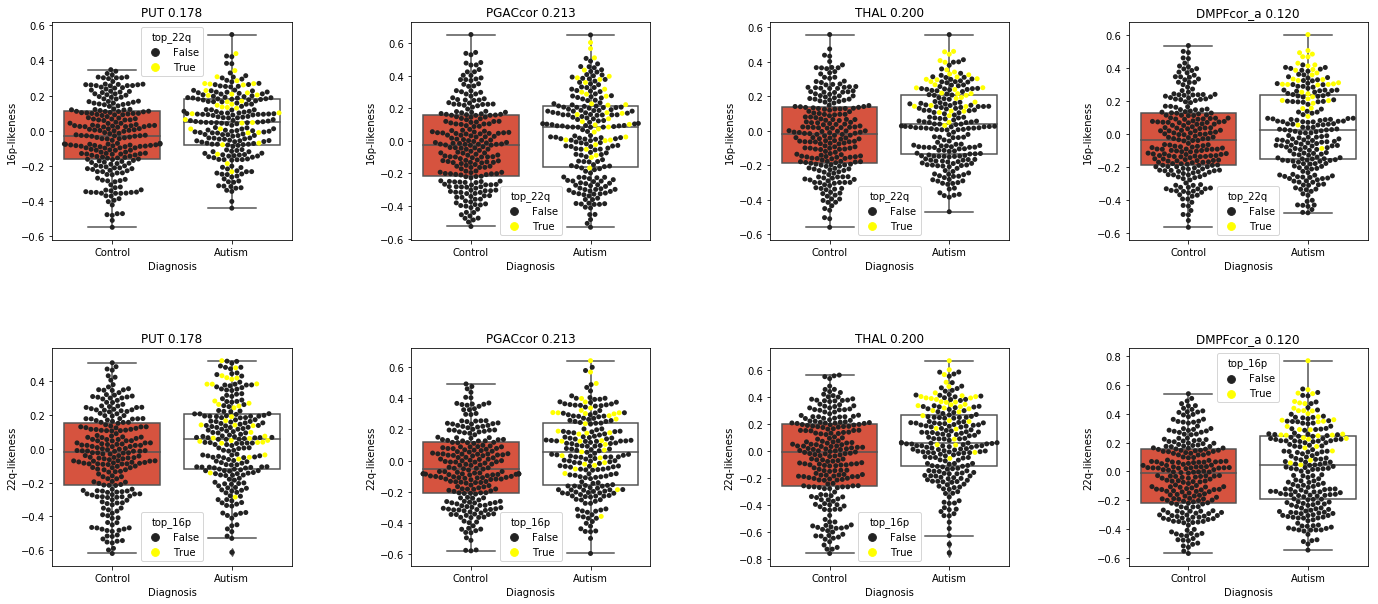

In [26]:
# We have 20 significant tests
f = plt.figure(figsize=(30,10))
gsp = gridspec.GridSpec(2, 5, hspace=0.5, wspace=0.5)
for fig_id, ind in enumerate(overlap_networks):
    r_name = labels[labels['roi']==ind+1]['label'].values[0]
    ax1 = f.add_subplot(gsp[0, fig_id])
    ax2 = f.add_subplot(gsp[1, fig_id])
    p = pheno.copy()
    p['16p_weights'] = w_abide_16p[:, ind]
    p['22q_weights'] = w_abide_22q[:, ind]
    # Get the top contributors
    p16_asd_percentile = np.percentile(p.loc[p['DX_GROUP']=='Autism']['16p_weights'].values, 85)
    p['top_16p'] = (p['DX_GROUP']=='Autism').values & (p['16p_weights']>p16_asd_percentile).values

    q22_asd_percentile = np.percentile(p.loc[p['DX_GROUP']=='Autism']['22q_weights'].values, 85)
    p['top_22q'] = (p['DX_GROUP']=='Autism').values & (p['22q_weights']>q22_asd_percentile).values
    
    sbn.boxplot(y='16p_weights', x='DX_GROUP', data=p, ax=ax1, palette=sbn.xkcd_palette(['tomato', 'white']))
    sbn.swarmplot(y='16p_weights', x='DX_GROUP', data=p, ax=ax1, color='yellow', size=5, hue='top_22q')
    ax1.set_ylabel('16p-likeness')
    ax1.set_xlabel('Diagnosis')
    ax1.set_title('{} {:.3f}'.format(r_name, eff_ls[ind]))
    
    sbn.boxplot(y='22q_weights', x='DX_GROUP', data=p, ax=ax2, palette=sbn.xkcd_palette(['tomato', 'white']))
    sbn.swarmplot(y='22q_weights', x='DX_GROUP', data=p, ax=ax2, color='yellow', size=5, hue='top_16p')
    ax2.set_ylabel('22q-likeness')
    ax2.set_xlabel('Diagnosis')
    ax2.set_title('{} {:.3f}'.format(r_name, eff_ls[ind]))

f.savefig(os.path.join(figure_p, 'abide_overlapping_enrichment_regions_16p_and_22q.pdf'), dpi=300, bbox_inches='tight', pad_inches=0)

## Test if the 15% most similar and dissimilar ABIDE ASD subjects are different
For example on FIQ or motion

In [ ]:
# Motion

In [ ]:
pheno.FD_scrubbed

In [61]:
# For the 16p DEL-CON contrast
ind_asd = pheno.DX_GROUP=='Autism'

p_fd_16p = list()
for ind in dx_ind_p16:
    p16_asd_percentile = np.percentile(w_abide_16p[ind_asd, ind], 85)
    ind_asd_top = (w_abide_16p[:, ind]<p16_asd_percentile) & ind_asd
    ind_asd_bottom = (w_abide_16p[:, ind]>p16_asd_percentile) & ind_asd
    u_min, p = sp.stats.mannwhitneyu(pheno.loc[ind_asd_top].FD_scrubbed.values, pheno.loc[ind_asd_bottom].FD_scrubbed.values, alternative=None)
    p_fd_16p.append(p)
    if p<0.05:
        net_name = labels.loc[labels.roi==ind+1].label.values[0]
        top_mean = np.nanmean(pheno.loc[ind_asd_top].FD_scrubbed.values)
        bottom_mean = np.nanmean(pheno.loc[ind_asd_bottom].FD_scrubbed.values)
        print('Top 15% iASD for {} 16pDEL-CON have FD={:.2f} vs {:.2f} for the rest (p={:.3f})'.format(net_name,
                                                                                                        top_mean,
                                                                                                        bottom_mean, p))

Top 15% iASD for PGACcor 16pDEL-CON have FD=0.18 vs 0.17 for the rest (p=0.034)


In [62]:
np.where(stm(p_fd_16p, alpha=0.05, method='fdr_bh')[0])[0]

array([], dtype=int64)

In [63]:
# For the 16p DEL-CON contrast
ind_asd = pheno.DX_GROUP=='Autism'

p_fd_22q = list()
for ind in dx_ind:
    
    p22_asd_percentile = np.percentile(w_abide_22q[ind_asd, ind], 85)
    ind_asd_top = (w_abide_22q[:, ind]<p22_asd_percentile) & ind_asd
    ind_asd_bottom = (w_abide_22q[:, ind]>p22_asd_percentile) & ind_asd
    u_min, p = sp.stats.mannwhitneyu(pheno.loc[ind_asd_top].FD_scrubbed.values, pheno.loc[ind_asd_bottom].FD_scrubbed.values, alternative=None)
    p_fd_22q.append(p)
    if p<0.05:
        net_name = labels.loc[labels.roi==ind+1].label.values[0]
        top_mean = np.nanmean(pheno.loc[ind_asd_top].FD_scrubbed.values)
        bottom_mean = np.nanmean(pheno.loc[ind_asd_bottom].FD_scrubbed.values)
        print('Top 15% iASD for {} 22qDEL-CON have FD={:.2f} vs {:.2f} for the rest (p={:.3f})'.format(net_name,
                                                                                                        top_mean,
                                                                                                        bottom_mean, p))

Top 15% iASD for PUT 22qDEL-CON have FD=0.18 vs 0.17 for the rest (p=0.038)
Top 15% iASD for THAL 22qDEL-CON have FD=0.18 vs 0.16 for the rest (p=0.009)
Top 15% iASD for CER7ab 22qDEL-CON have FD=0.18 vs 0.20 for the rest (p=0.020)
Top 15% iASD for MTgyr_a 22qDEL-CON have FD=0.18 vs 0.17 for the rest (p=0.046)


In [64]:
np.where(stm(p_fd_22q, alpha=0.05, method='fdr_bh')[0])[0]

array([], dtype=int64)

## FIQ

In [48]:
# For the 16p DEL-CON contrast
ind_asd = pheno.DX_GROUP=='Autism'
val = pheno.FIQ.values
p_fiq_16p = list()
for ind in dx_ind:
    
    p16_asd_percentile = np.percentile(w_abide_16p[ind_asd, ind], 85)
    ind_asd_top = (w_abide_16p[:, ind]<p16_asd_percentile) & ind_asd
    ind_asd_bottom = (w_abide_16p[:, ind]>p16_asd_percentile) & ind_asd
    u_min, p = sp.stats.mannwhitneyu(val[ind_asd_top], val[ind_asd_bottom], alternative=None)
    p_fiq_16p.append(p)
    if p<0.05:
        net_name = labels.loc[labels.roi==ind+1].label.values[0]
        top_mean = np.nanmean(val[ind_asd_top])
        bottom_mean = np.nanmean(val[ind_asd_bottom])
        val_mask = ~np.isnan(val) & ind_asd
        c, cp = stats.pearsonr(val[val_mask], w_abide_22q[val_mask, ind])
        print('Top 15% iASD for {} 16pDEL-CON have FIQ={:.2f} vs {:.2f} '
              'for the rest (p={:.3f}) (r={:.2f}, p={:.4f})'.format(net_name,
                                                                    top_mean,
                                                                    bottom_mean, p,
                                                                    c, cp))

Top 15% iASD for PUT 16pDEL-CON have FIQ=104.77 vs 96.97 for the rest (p=0.024)
Top 15% iASD for MOTnet_vl 16pDEL-CON have FIQ=104.49 vs 98.74 for the rest (p=0.032)


In [50]:
np.where(stm(p_fiq_16p, alpha=0.05, method='fdr_bh')[0])[0]

array([], dtype=int64)

In [71]:
# For the 16p DEL-CON contrast
ind_asd = pheno.DX_GROUP=='Autism'
val = pheno.FIQ.values
p_fiq_22q = list()
for ind in dx_ind:
    
    p22_asd_percentile = np.percentile(w_abide_22q[ind_asd, ind], 85)
    ind_asd_top = (w_abide_22q[:, ind]<p22_asd_percentile) & ind_asd
    ind_asd_bottom = (w_abide_22q[:, ind]>p22_asd_percentile) & ind_asd
    u_min, p = sp.stats.mannwhitneyu(val[ind_asd_top], val[ind_asd_bottom], alternative=None)
    p_fiq_22q.append(p)
    if p<0.05:
        net_name = labels.loc[labels.roi==ind+1].label.values[0]
        top_mean = np.nanmean(val[ind_asd_top])
        bottom_mean = np.nanmean(val[ind_asd_bottom])
        val_mask = ~np.isnan(val) & ind_asd
        c, cp = stats.pearsonr(val[val_mask], w_abide_22q[val_mask, ind])
        print('Top 15% iASD for {} 22qDEL-CON have FIQ={:.2f} vs {:.2f} '
              'for the rest (p={:.3f}) (r={:.2f}, p={:.4f})'.format(net_name,
                                                                    top_mean,
                                                                    bottom_mean, p,
                                                                    c, cp))

Top 15% iASD for PCcor_d 22qDEL-CON have FIQ=104.47 vs 98.85 for the rest (p=0.013) (r=-0.17, p=0.0095)
Top 15% iASD for AINS_v_PIsul 22qDEL-CON have FIQ=104.36 vs 99.47 for the rest (p=0.041) (r=-0.20, p=0.0025)
Top 15% iASD for ORBcor 22qDEL-CON have FIQ=104.81 vs 96.94 for the rest (p=0.002) (r=-0.11, p=0.1157)
Top 15% iASD for MFgyr_a 22qDEL-CON have FIQ=104.76 vs 97.03 for the rest (p=0.017) (r=-0.07, p=0.2715)
